In [1]:
import matplotlib.pyplot as plt
from python.middlebury import computeColor, readflo
from PIL import Image
from numpy import gradient
import numpy as np
import time
import optuna

/Users/hugoriffaud/Desktop/VISION/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


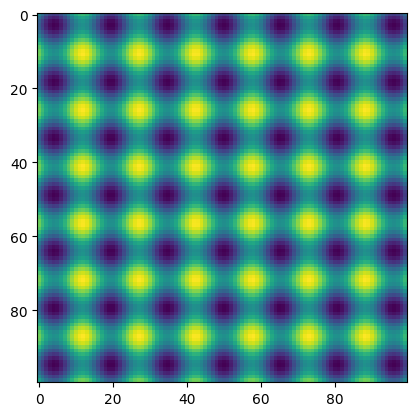

In [2]:
mysine1 = np.array(Image.open('./data/mysine/mysine9.png').convert('L'))
mysine2 = np.array(Image.open('./data/mysine/mysine10.png').convert('L'))

plt.imshow(mysine1)

In [3]:
def rne(Wr, We, eps=1e-10):
  return (np.linalg.norm(Wr) - np.linalg.norm(We)) / (np.linalg.norm(Wr) + eps)

def epe(Wr, We):
  return np.linalg.norm(Wr - We)

def repe(Wr, We, eps=1e-10):
  return (np.linalg.norm(Wr - We)) / (np.linalg.norm(Wr) + eps)

def angular_error(Wr, We):
  return np.arccos((1 + np.dot(Wr.T, We)) / (np.sqrt(1 + np.linalg.norm(Wr)**2) * np.sqrt(1 + np.linalg.norm(We)**2)))

In [4]:
def gradhorn(I1,I2):
  Ix = np.zeros(I1.shape)
  Iy = np.zeros(I1.shape)
  It = np.zeros(I1.shape)

  for i in range(Ix.shape[0]-1):
    for j in range(Ix.shape[1]-1):
      Ix[i,j] = 1/4 * (I1[i,j+1] - I1[i,j] + I1[i+1,j+1] - I1[i+1,j] + I2[i,j+1] - I2[i,j] + I2[i+1,j+1] - I2[i+1,j])
      Iy[i,j] = 1/4 * (I1[i+1,j] - I1[i,j] + I1[i+1,j+1] - I1[i,j+1] + I2[i+1,j] - I2[i,j] + I2[i+1,j+1] - I2[i,j+1])
      It[i,j] = 1/4 * (I2[i,j] - I1[i,j] + I2[i+1,j] - I1[i+1,j] + I2[i,j+1] - I1[i,j+1] + I2[i+1,j+1] - I1[i+1,j+1])

  return Ix, Iy, It


def gradhorn_vec(I1,I2):
    dx=np.empty((I1.shape[0],I1.shape[1]))
    dy=np.empty((I1.shape[0],I1.shape[1]))
    dz=np.empty((I1.shape[0],I1.shape[1]))

    dx[:,-1]=0.0
    dx[-1,:]=0.0
    dy[:,-1]=0.0
    dy[-1,:]=0.0
    dz[:,-1]=0.0
    dz[-1,:]=0.0
    
    dx[:-1,:-1]= I1[:-1,1:] #i j+1
    dx[:-1,:-1]-=I1[:-1,:-1] #i j
    dx[:-1,:-1]+= I1[1:,1:]  #i+1 j+1
    dx[:-1,:-1]-=I1[1:,:-1]  #i+1 j
    
    dx[:-1,:-1]+= I2[:-1,1:]  #i j+1
    dx[:-1,:-1]-=I2[:-1,:-1] #i j
    dx[:-1,:-1]+= I2[1:,1:]  #i+1 j+1
    dx[:-1,:-1]-=I2[1:,:-1]  #i+1 j

    dy[:-1,:-1]= I1[1:,:-1] #i j+1
    dy[:-1,:-1]-=I1[:-1,:-1] #i j
    dy[:-1,:-1]+= I1[1:,1:]  #i+1 j+1
    dy[:-1,:-1]-=I1[:-1,1:]  #i+1 j
    
    dy[:-1,:-1]+= I2[1:,:-1]  #i j+1
    dy[:-1,:-1]-=I2[:-1,:-1] #i j
    dy[:-1,:-1]+= I2[1:,1:]  #i+1 j+1
    dy[:-1,:-1]-=I2[:-1,1:]  #i+1 j

    dz[:-1,:-1]= I2[:-1,:-1] #i j+1
    dz[:-1,:-1]-= I1[:-1,:-1] #i j
    dz[:-1,:-1]+= I2[1:,:-1]  #i+1 j+1
    dz[:-1,:-1]-=I1[1:,:-1]  #i+1 j
    
    dz[:-1,:-1]+= I2[:-1,1:]  #i j+1
    dz[:-1,:-1]-=I1[:-1,1:] #i j
    dz[:-1,:-1]+= I2[1:,1:]  #i+1 j+1
    dz[:-1,:-1]-=I1[1:,1:]  #i+1 j

    return dx*0.25,dy*0.25,dz*0.25

Temps d execution boucle for:  0.09732  temps d execution vec: 0.00077
The vectorized version is equal to the loops version?:  True True True


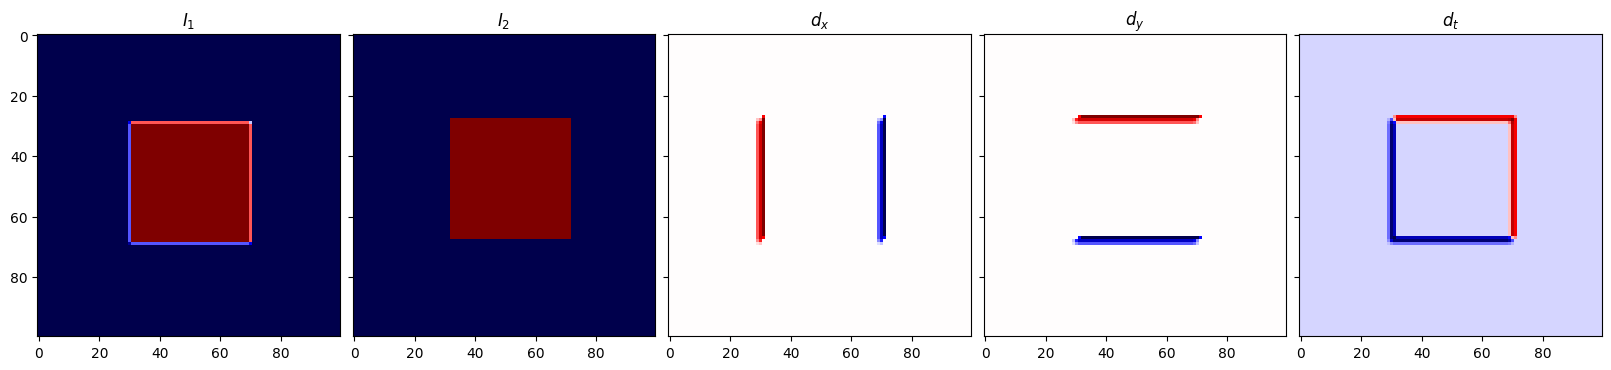

In [5]:
mysine1 = np.array(Image.open('./data/square/square9.png').convert('L'),dtype=np.float32)
mysine2 = np.array(Image.open('./data/square/square10.png').convert('L'),dtype=np.float32)

start_vec = time.time()
Ix,Iy,It=gradhorn_vec(mysine1.copy(),mysine2.copy())
end_vec = time.time()


axs = (plt.figure(figsize=plt.figaspect(0.25),constrained_layout=True)
       .subplots(1, 5, sharex=True, sharey=True))
axs[0].imshow(mysine1,cmap="seismic")
axs[0].set_title('$I_1$')
axs[1].imshow(mysine2,cmap="seismic")
axs[1].set_title('$I_2$')
axs[2].imshow(Ix,cmap="seismic")
axs[2].set_title('$d_x$')
axs[3].imshow(Iy,cmap="seismic")
axs[3].set_title('$d_y$')
axs[4].imshow(It,cmap="seismic")
axs[4].set_title('$d_t$')

mysine1 = np.array(Image.open('./data/square/square9.png').convert('L'),dtype=np.float32)
mysine2 = np.array(Image.open('./data/square/square10.png').convert('L'),dtype=np.float32)

start = time.time()
Ix_prec,Iy_prec,It_prec=gradhorn(mysine1,mysine2)
end = time.time()
print("Temps d execution boucle for: ",np.around(end - start,5)," temps d execution vec:",np.around(end_vec - start_vec,5))

print("The vectorized version is equal to the loops version?: ",np.allclose(Ix,Ix_prec),np.allclose(Iy,Iy_prec),np.allclose(It,It_prec))

In [6]:
def lucas(I1,I2,n):
    Ix, Iy, It = gradhorn_vec(I1,I2)
    W=np.zeros((I1.shape[0],I1.shape[1],2))
    
    half_window = n // 2

    for i in range(half_window, I1.shape[0] - half_window):
      for j in range(half_window, I1.shape[1] - half_window):
          Ix_window = Ix[i-half_window:i+half_window+1, j-half_window:j+half_window+1].flatten()
          Iy_window = Iy[i-half_window:i+half_window+1, j-half_window:j+half_window+1].flatten()
          It_window = It[i-half_window:i+half_window+1, j-half_window:j+half_window+1].flatten()
    
          A = np.vstack((Ix_window, Iy_window)).T
          b = -It_window
    
          if np.linalg.det(A.T @ A) != 0:
              nu = np.linalg.pinv(A.T @ A) @ A.T @ b
              W[i,j,0] = nu[0]
              W[i,j,1] = nu[1]
    
    return W

Text(0.5, 1.0, '$W$')

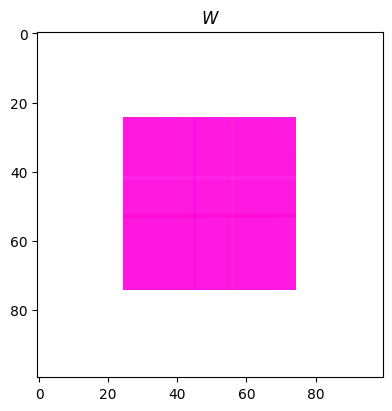

In [7]:
mysine1 = np.array(Image.open('./data/square/square9.png').convert('L'),dtype=np.float32)
mysine2 = np.array(Image.open('./data/square/square10.png').convert('L'),dtype=np.float32)

W = lucas(mysine1, mysine2, 50)


x,y = np.meshgrid(np.arange(0,mysine1.shape[0],1),np.arange(0,mysine1.shape[0],1))


axs = (plt.figure(figsize=plt.figaspect(0.25),constrained_layout=True)
       .subplots(1, 1, sharex=True, sharey=True))
axs.imshow(computeColor(W,True))
#axs.quiver(y,x,W[x,y,0],-W[x,y,1],alpha = 0.5,scale = 10.5)
axs.set_title('$W$')

Text(0.5, 1.0, '$W$')

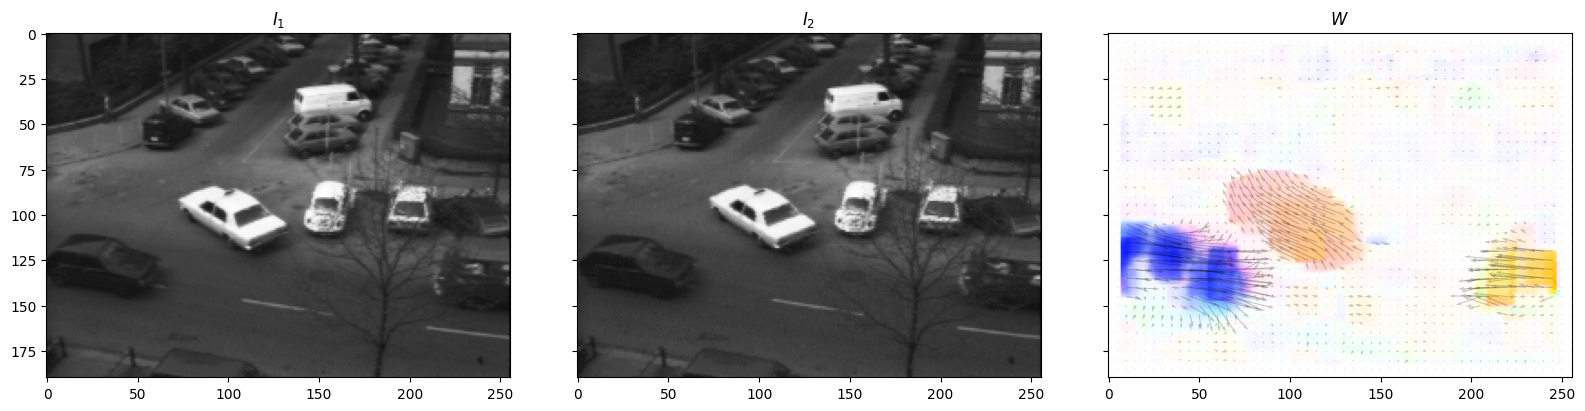

In [8]:
mysine1 = np.array(Image.open('./data/taxi/taxi9.png').convert('L'),dtype=np.float32)
mysine2 = np.array(Image.open('./data/taxi/taxi10.png').convert('L'),dtype=np.float32)

W = lucas(mysine1, mysine2, 15)


x,y = np.meshgrid(np.arange(0,mysine1.shape[0],5),np.arange(0,mysine1.shape[1],5))


axs = (plt.figure(figsize=plt.figaspect(0.25),constrained_layout=True)
       .subplots(1, 3, sharex=True, sharey=True))
axs[0].imshow(mysine1,cmap="gray")
axs[0].set_title('$I_1$')
axs[1].imshow(mysine2,cmap="gray")
axs[1].set_title('$I_2$')
axs[2].imshow(computeColor(W, True))
axs[2].quiver(y,x,W[x,y,0],-W[x,y,1],alpha = 0.2,scale = 6.3)
axs[2].set_title('$W$')

1.570718207863639
67.88  &  0.2  &  0.6


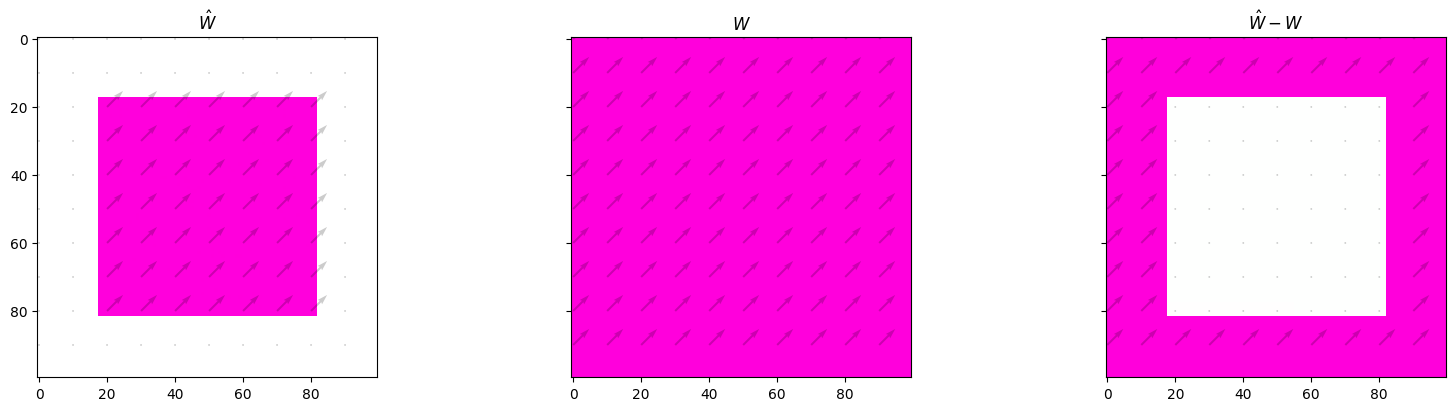

In [105]:
mysine1 = np.array(Image.open('./data/mysine/mysine9.png').convert('L'),dtype=np.float32)
mysine2 = np.array(Image.open('./data/mysine/mysine10.png').convert('L'),dtype=np.float32)
ground_truth_W = readflo('./data/mysine/correct_mysine.flo')

n=36
W = lucas(mysine1, mysine2, 36)

#rne
#epe
#repe
#angular_error


rne_tmp=(rne(ground_truth_W[int(n/2.0):-int(n/2.0)],W[int(n/2.0):-int(n/2.0)]))
epe_tmp=(epe(ground_truth_W[int(n/2.0):-int(n/2.0)],W[int(n/2.0):-int(n/2.0)]))
repe_tmp=(repe(ground_truth_W[int(n/2.0):-int(n/2.0)],W[int(n/2.0):-int(n/2.0)]))
print(np.mean(angular_error(ground_truth_W,W)))

print(np.around(epe_tmp,2)," & ",np.around(rne_tmp,2)," & ",np.around(repe_tmp,2))

x,y = np.meshgrid(np.arange(0,mysine1.shape[0],10),np.arange(0,mysine1.shape[1],10))


axs = (plt.figure(figsize=plt.figaspect(0.25),constrained_layout=True)
       .subplots(1, 3, sharex=True, sharey=True))

axs[0].imshow(computeColor(W, True))
axs[0].quiver(y,x,W[x,y,0],-W[x,y,1],alpha = 0.2,scale = 15.)
axs[0].set_title('$\hat{W}$')
axs[1].imshow(computeColor(ground_truth_W, True))
axs[1].quiver(y,x,ground_truth_W[x,y,0],-ground_truth_W[x,y,1],alpha = 0.2,scale = 15.)
axs[1].set_title('$W$')
axs[2].imshow(computeColor(ground_truth_W-W, True))
axs[2].quiver(y,x,ground_truth_W[x,y,0]-W[x,y,0],-ground_truth_W[x,y,1]+W[x,y,1],alpha = 0.2,scale = 15.)
axs[2].set_title('$\hat{W}-W$')

plt.savefig("Yosemite.pdf",format='pdf',bbox_inches='tight')


In [74]:
L_in=[]
L_out=[]



def add_L(path_pic1,path_pic2,path_W,L_in,L_out):
    pic1 = np.array(Image.open(path_pic1).convert('L'),dtype=np.float32)
    pic2 = np.array(Image.open(path_pic2).convert('L'),dtype=np.float32)
    ground_truth_W = readflo(path_W)
    L_in.append((pic1,pic2))
    L_out.append(ground_truth_W)
    return L_in,L_out

add_L('./data/yosemite/yos9.png','./data/yosemite/yos10.png','./data/yosemite/correct_yos.flo',L_in,L_out)
#add_L('./data/rubberwhale/frame10.png','./data/rubberwhale/frame11.png','./data/rubberwhale/correct_rubberwhale10.flo',L_in,L_out)
add_L('./data/square/square9.png','./data/square/square10.png','./data/square/correct_square.flo',L_in,L_out)
add_L('./data/mysine/mysine9.png','./data/mysine/mysine10.png','./data/mysine/correct_mysine.flo',L_in,L_out)
    

def objective_bayesian(trial):

    n = trial.suggest_int("n", 1, 50)

    score_trial=0.0
    
    for tmp_idx in range(len(L_in)):
        W_tmp=lucas(L_in[tmp_idx][0], L_in[tmp_idx][1], n)
        score_trial+=np.mean(np.abs(W_tmp[int(n/2.0):-int(n/2.0)]-L_out[tmp_idx][int(n/2.0):-int(n/2.0)]))
        #score_trial+=repe(L_out[tmp_idx][int(n/2.0):-int(n/2.0)],W_tmp[int(n/2.0):-int(n/2.0)])
        

    return score_trial

optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study()
study.optimize(objective_bayesian, n_trials=30)


n_res = study.best_params["n"]
print(n_res)

[I 2024-01-21 23:50:27,598] A new study created in memory with name: no-name-5b422dd1-af43-43c0-9090-aa0725cf70e5
[I 2024-01-21 23:50:33,014] Trial 0 finished with value: 2.0379833273244548 and parameters: {'n': 4}. Best is trial 0 with value: 2.0379833273244548.
[I 2024-01-21 23:50:38,466] Trial 1 finished with value: 1.8364013040791116 and parameters: {'n': 19}. Best is trial 1 with value: 1.8364013040791116.
[I 2024-01-21 23:50:43,812] Trial 2 finished with value: 2.0379833273244548 and parameters: {'n': 4}. Best is trial 1 with value: 1.8364013040791116.
[I 2024-01-21 23:50:49,400] Trial 3 finished with value: 1.620058394475672 and parameters: {'n': 26}. Best is trial 3 with value: 1.620058394475672.
[I 2024-01-21 23:50:55,157] Trial 4 finished with value: 1.5731950480064882 and parameters: {'n': 42}. Best is trial 4 with value: 1.5731950480064882.
[I 2024-01-21 23:51:01,200] Trial 5 finished with value: 1.6681770472754636 and parameters: {'n': 46}. Best is trial 4 with value: 1.57

36


Text(0.5, 1.0, '$W-\\hat{W}$')

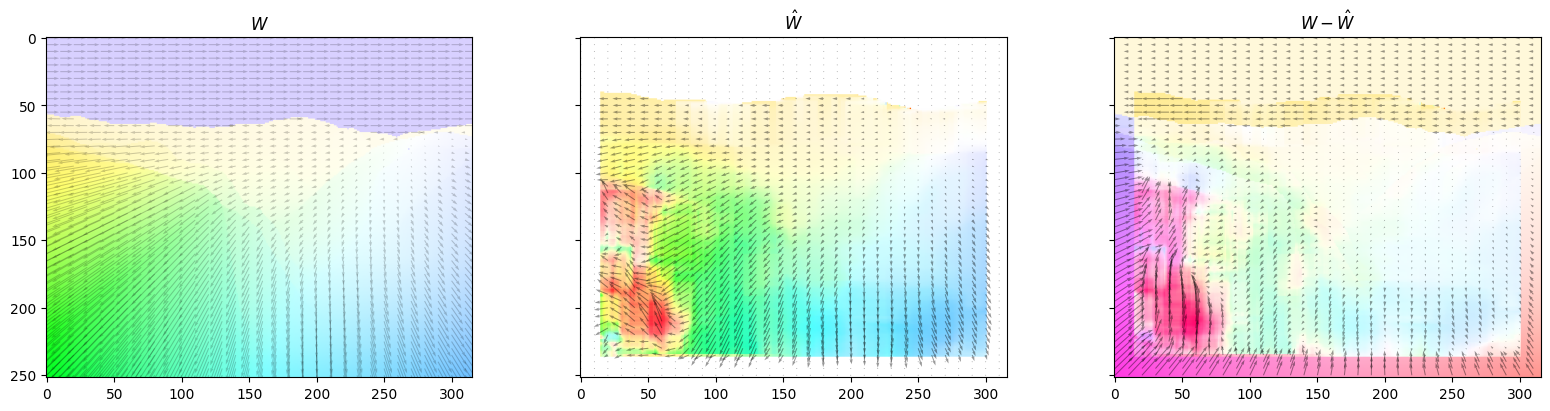

In [11]:
mysine1 = np.array(Image.open('./data/yosemite/yos9.png').convert('L'),dtype=np.float32)
mysine2 = np.array(Image.open('./data/yosemite/yos10.png').convert('L'),dtype=np.float32)
ground_truth_W = readflo('./data/yosemite/correct_yos.flo')


W = lucas(mysine1, mysine2, 30)
x,y = np.meshgrid(np.arange(0,mysine1.shape[0],5),np.arange(0,mysine1.shape[1],10))


axs = (plt.figure(figsize=plt.figaspect(0.25),constrained_layout=True)
       .subplots(1, 3, sharex=True, sharey=True))

axs[0].imshow(computeColor(ground_truth_W, True),cmap="gray")
axs[0].quiver(y,x,ground_truth_W[x,y,0],-ground_truth_W[x,y,1],alpha = 0.2,scale = 6.3)
axs[0].set_title('$W$')
axs[1].imshow(computeColor(W, True))
axs[1].quiver(y,x,W[x,y,0],-W[x,y,1],alpha = 0.4,scale = 16.3)
axs[1].set_title('$\hat{W}$')
axs[2].imshow(computeColor(W-ground_truth_W, True))
axs[2].quiver(y,x,W[x,y,0]-ground_truth_W[x,y,0],-W[x,y,1]+ground_truth_W[x,y,1],alpha = 0.4,scale = 16.3)
axs[2].set_title('$W-\hat{W}$')


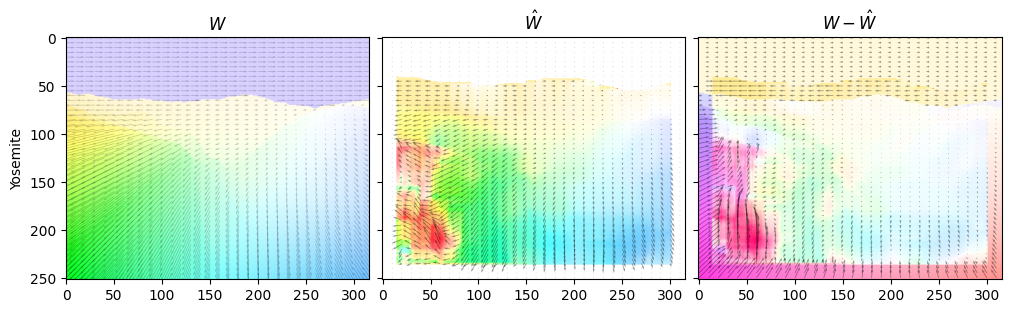

In [12]:
mysine1 = np.array(Image.open('./data/yosemite/yos9.png').convert('L'),dtype=np.float32)
mysine2 = np.array(Image.open('./data/yosemite/yos10.png').convert('L'),dtype=np.float32)
ground_truth_W = readflo('./data/yosemite/correct_yos.flo')

#nasa

W = lucas(mysine1, mysine2, 30)
x,y = np.meshgrid(np.arange(0,mysine1.shape[0],5),np.arange(0,mysine1.shape[1],10))


axs = (plt.figure(figsize=(10,8),constrained_layout=True)
       .subplots(1, 3, sharex=True, sharey=True))

axs[0].imshow(computeColor(ground_truth_W, True),cmap="gray")
axs[0].quiver(y,x,ground_truth_W[x,y,0],-ground_truth_W[x,y,1],alpha = 0.2,scale = 6.3)
axs[0].set_title('$W$')
axs[0].set_ylabel('Yosemite')
axs[1].imshow(computeColor(W, True))
axs[1].quiver(y,x,W[x,y,0],-W[x,y,1],alpha = 0.4,scale = 16.3)
axs[1].set_title('$\hat{W}$')
axs[2].imshow(computeColor(W-ground_truth_W, True))
axs[2].quiver(y,x,W[x,y,0]-ground_truth_W[x,y,0],-W[x,y,1]+ground_truth_W[x,y,1],alpha = 0.4,scale = 16.3)
axs[2].set_title('$W-\hat{W}$')

plt.savefig("Yosemite.pdf",format='pdf',bbox_inches='tight')

Text(0.5, 1.0, '$W-\\hat{W}$')

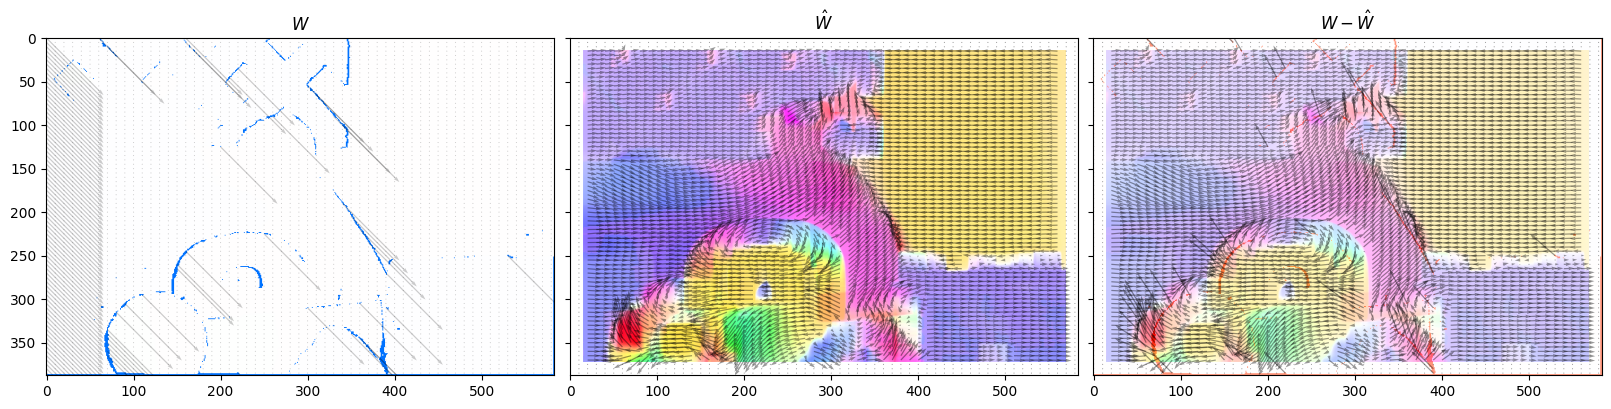

In [13]:
mysine1 = np.array(Image.open('./data/rubberwhale/frame10.png').convert('L'),dtype=np.float32)
mysine2 = np.array(Image.open('./data/rubberwhale/frame11.png').convert('L'),dtype=np.float32)
ground_truth_W = readflo('./data/rubberwhale/correct_rubberwhale10.flo')


W = lucas(mysine1, mysine2, 30)
x,y = np.meshgrid(np.arange(0,mysine1.shape[0],5),np.arange(0,mysine1.shape[1],10))


axs = (plt.figure(figsize=plt.figaspect(0.25),constrained_layout=True)
       .subplots(1, 3, sharex=True, sharey=True))

axs[0].imshow(computeColor(ground_truth_W, True),cmap="gray")
axs[0].quiver(y,x,ground_truth_W[x,y,0],-ground_truth_W[x,y,1],alpha = 0.2,scale = 6.3)
axs[0].set_title('$W$')
axs[1].imshow(computeColor(W, True))
axs[1].quiver(y,x,W[x,y,0],-W[x,y,1],alpha = 0.4,scale = 16.3)
axs[1].set_title('$\hat{W}$')
axs[2].imshow(computeColor(W-ground_truth_W, True))
axs[2].quiver(y,x,W[x,y,0]-ground_truth_W[x,y,0],-W[x,y,1]+ground_truth_W[x,y,1],alpha = 0.4,scale = 16.3)
axs[2].set_title('$W-\hat{W}$')
